Using 'nd2' library for ND2 support
Please select the folder containing image files...
Searching for image files in C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/Gel microscopy/13OCT25/2% gelatin/25 ug-mL/MSN/6-2; 28 cycles...
Found 6 image files: 0 TIFF, 6 ND2

Original image scale: 3.107402847011195 µm/pixel (source: ND2 voxel_size method)


Proceed with stitching 6 images side by side? (Y/n):  y


Stitching images side by side...
Using scale: 3.107402847011195 µm/pixel (source: ND2 voxel_size method)
Loaded MSN_28 cycles_1.nd2 (ND2), shape: (8397, 2867)
Loaded MSN_28 cycles_2_retry.nd2 (ND2), shape: (8397, 2867)
Loaded MSN_28 cycles_3.nd2 (ND2), shape: (8397, 2867)
Loaded MSN_28 cycles_4.nd2 (ND2), shape: (8397, 2867)
Loaded MSN_28 cycles_5.nd2 (ND2), shape: (8397, 2867)
Loaded MSN_28 cycles_6.nd2 (ND2), shape: (8397, 2867)

Stitched Image Information:
  Dimensions: 17202 x 8397 pixels
  Scale: 3.107402847011195 µm/pixel
  Physical Size: 53453.54 µm × 26092.86 µm
Saving with exact scale: 3.107402847011195 µm/pixel
(Equivalent to 3218.12 pixels/cm for TIFF resolution)


C:\ProgramData\anaconda3\envs\particle_tracker_real\Lib\site-packages\tifffile\tifffile.py:2437: UserWarning: <tifffile.TiffWriter '6-2; 28 cycles_stitched.tiff'> not writing description to OME-TIFF
  warnings.warn(


✓ Saved with all forms of scale information

Verifying scale info in: 6-2; 28 cycles_stitched.tiff
✓ Found scale: 3.1074020087503365 µm/pixel (source: TIFF resolution (cm))


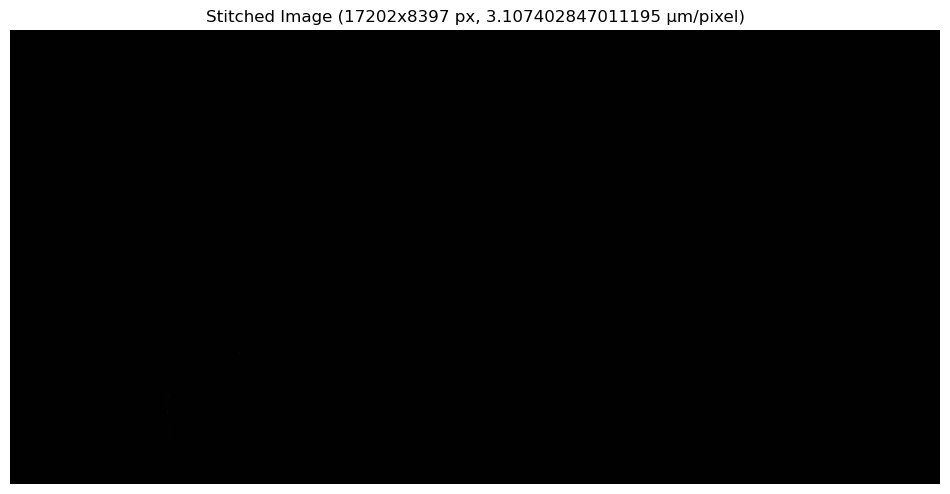


Successfully stitched 6 images side by side
Stitched image saved to C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/Gel microscopy/13OCT25/2% gelatin/25 ug-mL/MSN/6-2; 28 cycles\stitched_image\6-2; 28 cycles_stitched.tiff


In [9]:
# Import necessary libraries
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import xml.etree.ElementTree as ET
import re

# Try to import ND2 libraries with fallbacks
try:
    import nd2
    ND2_SUPPORT = "nd2"
    print("Using 'nd2' library for ND2 support")
except ImportError:
    try:
        import nd2reader
        ND2_SUPPORT = "nd2reader"
        print("Using 'nd2reader' library for ND2 support")
    except ImportError:
        try:
            import pims
            ND2_SUPPORT = "pims"
            print("Using 'pims' library for ND2 support")
        except ImportError:
            ND2_SUPPORT = None
            print("ND2 support disabled. To enable, install: pip install nd2")

def select_folder(title="Select Folder"):
    """Open a tkinter dialog to select a folder"""
    root = tk.Tk()
    root.withdraw()
    root.attributes('-topmost', True)
    folder_path = filedialog.askdirectory(title=title, parent=root)
    root.destroy()
    return folder_path

def find_image_files(root_dir):
    """Find all supported image files (TIFF and ND2) in a directory (non-recursive)"""
    image_files = []
    # Only check items in the root directory (no recursion)
    for item in os.listdir(root_dir):
        full_path = os.path.join(root_dir, item)
        # Only process files (skip directories)
        if os.path.isfile(full_path):
            lower_file = item.lower()
            if lower_file.endswith(('.tif', '.tiff')):
                image_files.append(full_path)
            elif lower_file.endswith('.nd2') and ND2_SUPPORT:
                image_files.append(full_path)
    return image_files

def read_nd2_image(file_path):
    """Read an ND2 file and return the image and metadata"""
    if ND2_SUPPORT == "nd2":
        with nd2.ND2File(file_path) as f:
            # Get first frame
            img = f.asarray()
            
            # Handle multi-dimensional data
            while len(img.shape) > 2:
                if img.shape[0] == 1:  # Z/T/C dimension
                    img = img[0]
                elif len(img.shape) == 3 and img.shape[2] <= 4:  # RGB/RGBA
                    img = np.mean(img, axis=2).astype(np.uint16)
                    break
                else:
                    img = img[0]  # Default: take first slice
            
            # Get metadata with scale information
            metadata = {}
            try:
                # Use voxel_size method directly
                if hasattr(f, 'voxel_size') and callable(f.voxel_size):
                    vs = f.voxel_size()
                    if vs is not None and len(vs) > 0:
                        metadata['pixel_size_um'] = vs[0]  # x dimension in micrometers
            except Exception as e:
                print(f"Error getting voxel size: {e}")
            
            return img, metadata
            
    elif ND2_SUPPORT == "nd2reader":
        with nd2reader.ND2Reader(file_path) as f:
            img = f[0]
            
            # Handle multi-dimensional data
            if len(img.shape) > 2 and img.shape[2] <= 4:  # RGB/RGBA
                img = np.mean(img, axis=2).astype(np.uint16)
                
            metadata = {}
            try:
                if hasattr(f, 'metadata'):
                    if isinstance(f.metadata, dict) and 'pixel_microns' in f.metadata:
                        metadata['pixel_size_um'] = f.metadata['pixel_microns']
            except Exception as e:
                print(f"Error accessing nd2reader metadata: {e}")
            
            return img, metadata
            
    elif ND2_SUPPORT == "pims":
        frames = pims.ND2_Reader(file_path)
        img = frames[0]
        
        # Handle multi-channel images
        if len(img.shape) > 2 and img.shape[2] <= 4:
            img = np.mean(img, axis=2).astype(np.uint16)
            
        metadata = {}
        try:
            if hasattr(frames, 'metadata'):
                if isinstance(frames.metadata, dict) and 'calibration_um' in frames.metadata:
                    metadata['pixel_size_um'] = frames.metadata['calibration_um']
        except Exception as e:
            print(f"Error accessing pims metadata: {e}")
        
        return img, metadata
    
    raise ValueError(f"Cannot read ND2 file: {file_path} - no ND2 support library available")

def extract_scale_info(file_path):
    """Extract scale information from a TIFF or ND2 file (um/pixel)"""
    scale_um_per_pixel = None
    scale_source = "unknown"
    
    # Handle ND2 files
    if file_path.lower().endswith('.nd2') and ND2_SUPPORT:
        try:
            if ND2_SUPPORT == "nd2":
                # Direct approach for nd2 library using voxel_size method
                with nd2.ND2File(file_path) as f:
                    try:
                        if hasattr(f, 'voxel_size') and callable(f.voxel_size):
                            vs = f.voxel_size()
                            if vs is not None and len(vs) > 0:
                                scale_um_per_pixel = vs[0]  # x dimension
                                scale_source = "ND2 voxel_size method"
                    except Exception as e:
                        print(f"Error accessing voxel_size: {e}")
            else:
                # Use the read_nd2_image function for other libraries
                _, metadata = read_nd2_image(file_path)
                if metadata and 'pixel_size_um' in metadata:
                    scale_um_per_pixel = metadata['pixel_size_um']
                    scale_source = f"ND2 metadata ({ND2_SUPPORT})"
            
            # If still no scale, use fallback
            if scale_um_per_pixel is None:
                scale_um_per_pixel = 1.625  # Fallback value
                scale_source = "hardcoded (ND2 metadata not found)"
                
        except Exception as e:
            print(f"Error extracting scale from ND2: {e}")
            scale_um_per_pixel = 1.625  # Fallback value
            scale_source = "hardcoded after ND2 error"
    
    # Handle TIFF files
    else:
        try:
            with tifffile.TiffFile(file_path) as tif:
                # Check OME metadata first
                if tif.ome_metadata:
                    # Try direct regex search for PhysicalSizeX
                    size_match = re.search(r'PhysicalSizeX="([^"]+)"', tif.ome_metadata)
                    unit_match = re.search(r'PhysicalSizeXUnit="([^"]+)"', tif.ome_metadata)
                    
                    if size_match:
                        scale_um_per_pixel = float(size_match.group(1))
                        scale_source = "OME metadata"
                        
                        # Check the unit to convert if needed
                        if unit_match:
                            unit = unit_match.group(1)
                            if unit.lower() in ('mm', 'millimeter', 'millimeters'):
                                scale_um_per_pixel *= 1000  # Convert mm to µm
                            elif unit.lower() in ('nm', 'nanometer', 'nanometers'):
                                scale_um_per_pixel /= 1000  # Convert nm to µm
                
                # Check standard TIFF resolution tags if no OME metadata
                if scale_um_per_pixel is None and 'XResolution' in tif.pages[0].tags:
                    x_resolution = tif.pages[0].tags['XResolution'].value
                    res_unit = tif.pages[0].tags.get('ResolutionUnit', 1).value
                    
                    if isinstance(x_resolution, tuple) and len(x_resolution) == 2:
                        dpi = float(x_resolution[0]) / float(x_resolution[1])
                        
                        # Convert based on resolution unit
                        if res_unit == 2:  # Inches
                            scale_um_per_pixel = 25400 / dpi  # 25400 µm per inch
                            scale_source = "TIFF resolution (inches)"
                        elif res_unit == 3:  # Centimeters
                            scale_um_per_pixel = 10000 / dpi  # 10000 µm per cm
                            scale_source = "TIFF resolution (cm)"
                
                # Fallback to hardcoded value based on our known source files
                if scale_um_per_pixel is None:
                    scale_um_per_pixel = 1.625  # Known value for our microscope
                    scale_source = "hardcoded default"
        
        except Exception as e:
            print(f"Error extracting scale: {e}")
            scale_um_per_pixel = 1.625  # Fallback to known value
            scale_source = "hardcoded after error"
    
    return scale_um_per_pixel, scale_source

def stitch_images_side_by_side(image_paths):
    """Place images side by side and extract scale info"""
    # Sort the image paths for consistent ordering
    image_paths = sorted(image_paths)
    
    # Get scale from first image
    scale_um_per_pixel, scale_source = extract_scale_info(image_paths[0])
    print(f"Using scale: {scale_um_per_pixel} µm/pixel (source: {scale_source})")
    
    # Load all images with better error handling
    images = []
    valid_paths = []
    
    for path in image_paths:
        try:
            # Handle ND2 files
            if path.lower().endswith('.nd2') and ND2_SUPPORT:
                img, _ = read_nd2_image(path)
                print(f"Loaded {os.path.basename(path)} (ND2), shape: {img.shape}")
                images.append(img)
                valid_paths.append(path)
            
            # Handle TIFF files
            else:
                with tifffile.TiffFile(path) as tif:
                    if len(tif.pages) == 0:
                        print(f"Warning: {os.path.basename(path)} contains no pages, skipping")
                        continue
                    
                    # Load the first page as 2D image
                    img = tif.pages[0].asarray()
                    
                    # If image is multi-dimensional, take first channel/Z-slice
                    while len(img.shape) > 2:
                        img = img[0]
                    
                    print(f"Loaded {os.path.basename(path)}, shape: {img.shape}")
                    images.append(img)
                    valid_paths.append(path)
        except Exception as e:
            print(f"Error loading {os.path.basename(path)}: {e}")
    
    if not images:
        raise ValueError("No valid images could be loaded for stitching")
    
    # Simple 2D stitching
    heights = [img.shape[0] for img in images]
    widths = [img.shape[1] for img in images]
    
    max_height = max(heights)
    total_width = sum(widths)
    
    # Create output array
    stitched = np.zeros((max_height, total_width), dtype=images[0].dtype)
    
    # Place images side by side
    x_offset = 0
    for img in images:
        h, w = img.shape
        # Center vertically
        y_offset = (max_height - h) // 2
        
        stitched[y_offset:y_offset+h, x_offset:x_offset+w] = img
        x_offset += w
    
    return stitched, scale_um_per_pixel


def save_stitched_image(stitched_img, scale_um_per_pixel, output_path):
    """Save the stitched image with exactly correct µm/pixel scale"""
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Get dimensions
    height, width = stitched_img.shape
    
    # For TIFF tags we need pixels per unit
    # Calculate the exact value for 1.625 µm/pixel
    # For unit=3 (cm), we need pixels per cm: 10000 µm/cm ÷ 1.625 µm/pixel = 6153.84615 pixels/cm
    pixels_per_cm = 10000.0 / scale_um_per_pixel  # 10000 µm per cm
    
    # Store the actual scale in description for direct access
    description = f"scale={scale_um_per_pixel}_um_per_pixel"
    
    # Create OME metadata with exact scale
    ome_metadata = f'''<?xml version="1.0" encoding="UTF-8"?>
<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06">
    <Image ID="Image:0" Name="Stitched Image">
        <Pixels ID="Pixels:0" DimensionOrder="XYZCT" Type="{stitched_img.dtype}" 
                SizeX="{width}" SizeY="{height}" SizeZ="1" SizeC="1" SizeT="1"
                PhysicalSizeX="{scale_um_per_pixel}" PhysicalSizeY="{scale_um_per_pixel}" 
                PhysicalSizeXUnit="um" PhysicalSizeYUnit="um">
        </Pixels>
    </Image>
</OME>'''
    
    print(f"Saving with exact scale: {scale_um_per_pixel} µm/pixel")
    print(f"(Equivalent to {pixels_per_cm:.2f} pixels/cm for TIFF resolution)")
    
    # Save with multiple forms of scale information for maximum compatibility
    try:
        tifffile.imwrite(
            output_path,
            stitched_img,
            photometric='minisblack',
            resolution=(pixels_per_cm, pixels_per_cm),  # Standard TIFF resolution
            resolutionunit=3,  # 3 = centimeters
            description=description,  # Embedded in description
            metadata={'ScaleUmPerPixel': scale_um_per_pixel},  # In metadata
            ome=ome_metadata  # In OME-XML
        )
        print("✓ Saved with all forms of scale information")
    except Exception as e:
        print(f"Error with full metadata save: {e}")
        
        # Fallback to minimal save with just the important tags
        try:
            tifffile.imwrite(
                output_path,
                stitched_img,
                resolution=(pixels_per_cm, pixels_per_cm),
                resolutionunit=3,  # 3 = centimeters
                description=description
            )
            print("Saved with basic resolution information")
        except Exception as e:
            print(f"Error with basic save: {e}")
            tifffile.imwrite(output_path, stitched_img)
            print("Saved without scale information")

def verify_scale_info(tiff_path):
    """Verify the scale information was properly saved"""
    print(f"\nVerifying scale info in: {os.path.basename(tiff_path)}")
    
    scale_um_per_pixel, source = extract_scale_info(tiff_path)
    
    if scale_um_per_pixel is not None:
        print(f"✓ Found scale: {scale_um_per_pixel} µm/pixel (source: {source})")
        return True
    else:
        print("✗ No scale information found")
        return False

def stitch_images_simple():
    """Main function to find and stitch image files side by side"""
    # Ask user to select input folder
    print("Please select the folder containing image files...")
    input_dir = select_folder("Select Folder")
    if not input_dir:
        print("No folder selected. Aborting.")
        return
    
    # Create output directory within the selected folder
    output_dir = os.path.join(input_dir, "stitched_image")
    os.makedirs(output_dir, exist_ok=True)
    
    # Find all supported image files
    print(f"Searching for image files in {input_dir}...")
    image_files = find_image_files(input_dir)
    
    # Count file types
    tiff_count = sum(1 for f in image_files if f.lower().endswith(('.tif', '.tiff')))
    nd2_count = sum(1 for f in image_files if f.lower().endswith('.nd2'))
    
    print(f"Found {len(image_files)} image files: {tiff_count} TIFF, {nd2_count} ND2")
    
    if len(image_files) == 0:
        print("No image files found in the selected directory.")
        supported = "TIFF (.tif, .tiff)"
        if ND2_SUPPORT:
            supported += ", ND2 (.nd2)"
        print(f"Supported formats: {supported}")
        return
    
    # Get original scale info from first file
    scale_um_per_pixel, source = extract_scale_info(image_files[0])
    print(f"\nOriginal image scale: {scale_um_per_pixel} µm/pixel (source: {source})")
    
    # Ask for confirmation
    # Ask for confirmation
    proceed = input(f"Proceed with stitching {len(image_files)} images side by side? (Y/n): ") or 'y'
    if proceed.lower() != 'y':
        print("Stitching cancelled.")
        return
    
    # Stitch all images side by side
    print("Stitching images side by side...")
    stitched_img, scale_um_per_pixel = stitch_images_side_by_side(image_files)
    
    # Show physical dimensions of stitched image
    height, width = stitched_img.shape
    total_width_um = width * scale_um_per_pixel
    total_height_um = height * scale_um_per_pixel
    print(f"\nStitched Image Information:")
    print(f"  Dimensions: {width} x {height} pixels")
    print(f"  Scale: {scale_um_per_pixel} µm/pixel")
    print(f"  Physical Size: {total_width_um:.2f} µm × {total_height_um:.2f} µm")
    
    # Create output filename
    base_dir_name = os.path.basename(input_dir)
    output_path = os.path.join(output_dir, f"{base_dir_name}_stitched.tiff")
    
    # Save with scale information
    save_stitched_image(stitched_img, scale_um_per_pixel, output_path)
    
    # Verify the scale information was saved
    verify_scale_info(output_path)
    
    # Preview result
    plt.figure(figsize=(12, 8))
    plt.imshow(stitched_img, cmap='gray')
    plt.title(f'Stitched Image ({width}x{height} px, {scale_um_per_pixel} µm/pixel)')
    plt.axis('off')
    plt.show()
    
    print(f"\nSuccessfully stitched {len(image_files)} images side by side")
    print(f"Stitched image saved to {output_path}")

# Run this function to start the stitching process
if __name__ == "__main__":
    stitch_images_simple()
